# A model of overlapping gradients of connectivity

L. Cerliani, M. Falkiewicz & D.S. Margulies

In [80]:
%matplotlib inline
import numpy as np

from mapalign import embed, dist, align
from scipy import stats, linalg

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.use('Agg')
plt.rcParams['backend'] = 'TkAgg'
plt.rcParams['image.cmap'] = 'jet'


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 36}

mpl.rc('font', **font)

from pySTATIS import statis as pstatis

In [74]:
def gen_probgrad(T, S, ol):
    
    '''
    T - target size
    S - source size
    ol - overlap
    '''
    
    SR = np.zeros([S,T])
    
    for i in range(S):
        ol1r = int(ol*np.random.random(1))
        st = i*T/S
        SR[i,:] = stats.norm.pdf(range(T),st+ol1r,int(S + 3*S*np.random.random(1))+1)
        
    return SR

def gen_connectivity(Sx, Sy, T1, T2, overlap = 2, snr = 3, rand_overlap = True, mode = 'probabilistic', plot = False):
    
    '''
    Sx - seed, first dimension
    Sy - seed, second dimension
    T1 - size of target of 1st dimension
    T2 - size of target of 2nd dimension
    overlap - overlap of two regions
    snr - noise level (higher -> less noise)
    rand_overlap - randomize the overlap level?
    
    returns:
    G - 3d matrix
    C - restructured G to 2d
    CN - above with added noise
    '''
    
    ol1 = int(T1/Sx*overlap)
    
    S_R1 = np.zeros([Sx,T1])
    for i in range(Sx):
        ol1r = int(ol1*np.random.random(1))
        if mode == 'determinstic' and rand_overlap:
            st = i*T1/Sx-ol1r
            if st < 0:
                st = 0
        else:
            st = i*T1/Sx
        
        if mode == 'deterministic':
            S_R1[i,st:i*T1/Sx+ol1+ol1r] = 1
        elif mode == 'probabilistic':
            S_R1[i,:] = norm.pdf(range(T1),st+ol1r,int(Sx + 3*Sx*np.random.random(1))+1)
            # Rescale the distribution to simulate different correlation values
            #m = np.max(S_R1)
            #c = np.random.normal(0.5,0.2)
            #S_R1[i,:] = S_R1[i,:]*(c/m)

    G1 = np.zeros([Sx,Sy,T1])
    for i in range(Sy):
        #G1[:,i,:] = S_R1
        G1[:,i,:] = gen_probgrad(T1, Sx, ol1)
    
    ol2 = int(T2/Sy*overlap)
    
 
    S_R2 = np.zeros([Sy,T2])
    for i in range(Sy):
        
        ol2r = int(ol2*np.random.random(1))
        
        if mode == 'deterministic' and rand_overlap:
            st = i*T2/Sy-ol2r
            if st < 0:
                st = 0
        else:
            st = i*T2/Sy
        
        if mode == 'deterministic':
            S_R2[i,st:i*T2/Sy+ol2+ol2r] = 1
        elif mode == 'probabilistic':
            S_R2[i,:] = norm.pdf(range(T2),st+ol2r,int(Sy + 3*Sy*np.random.random(1))+1)
            #m = np.max(S_R2)
            #c = np.random.normal(0.5,0.2)
            #S_R2[i,:] = S_R2[i,:]*(c/m)

    G2 = np.zeros([Sx,Sy,T2])
    for i in range(Sx):
        #G2[i,:,:] = S_R2
        G2[i,:,:] = gen_probgrad(T2, Sy, ol2)
    
    G = np.concatenate([G1,G2], axis = 2)
    
    C = np.zeros([Sx*Sy,T1+T2])

    for i in range(Sx):
        for j in range(Sy):
            C[i+j*Sx,:] = G[i,j,:]
    
    N = np.random.random(C.shape)
    N = (N - 0.5) / snr
    
    CN = C + N
    
    if plot:
        plt.matshow(CN)
    
    return C, CN, G

def compute_affinity(X, method='markov', eps=None, metric = 'euclidean'):
    import numpy as np
    from sklearn.metrics import pairwise_distances
    D = pairwise_distances(X, metric=metric)
    if eps is None:
        k = int(max(2, np.round(D.shape[0] * 0.01)))
        eps = 2 * np.median(np.sort(D, axis=0)[k+1, :])**2
    if method == 'markov':
        affinity_matrix = np.exp(-(D * D) / eps)
    elif method == 'cauchy':
        affinity_matrix = 1./(D * D + eps)
    return affinity_matrix

def reconstruct2(V, Sx, Sy):
    R = np.zeros([Sy, Sx])
    for i in range(Sy):
        R[i,:] = V[i*Sx:i*Sx+Sx]
    return R.T

def gen_gradients(X, Sx, Sy, metric = 'cityblock', method = 'diffusion', alpha = 0.5, dt = 0, plot = True):
    
    
    Aff = compute_affinity(X, metric = metric)
    Aff = dist.compute_nearest_neighbor_graph(Aff, 50)

    if method == 'diffusion':
        emb, res = embed.compute_diffusion_map(Aff, n_components = np.min([Sx,Sy]), alpha = alpha, diffusion_time = dt)
        #print res['orig_lambdas']
    elif method == 'laplacian':
        from sklearn import manifold
        emb = manifold.SpectralEmbedding(n_components=np.min([Sx,Sy])).fit_transform(Aff)
    
    
    if plot:
        plt.matshow(Aff.toarray(), cmap='jet')
        plt.colorbar()
        plt.title('Affinity matrix')
        plt.show()    

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(emb[:,0], emb[:,1], emb[:,2], c = range(X.shape[0]), cmap='jet')
        plt.title('Three components')
        plt.show()

        plt.scatter(emb[:,0], emb[:,1], c = range(X.shape[0]),cmap='jet')
        plt.title("Component 0 vs 1")
        plt.colorbar()
        plt.show()

        plt.scatter(emb[:,1], emb[:,2], c = range(X.shape[0]),cmap='jet')
        plt.title("Component 1 vs 2")
        plt.colorbar()
        plt.show()    

        for i in range(emb.shape[1]):
            R = reconstruct2(emb[:,i], Sx, Sy)
            plt.matshow(R, cmap='jet')
            plt.title("Component %d" % i)
            plt.colorbar()
            plt.show()

    return emb, res

# Introduction

In the above functions we attempt to model the diffusion embedding of single brain area's connectivity. The area contains two overlaping gradients of connectivity with separate brain areas. The goal is to establish whether diffusion embedding allows for accurate recovery the overlapping gradients. The modeling proceeds in following steps:
1. Generation of connectivity matrix between seed and target regions
2. Embedding of the connectivity matrix
3. Testing of realignment procedures (Generalized Procrustes and STATIS)

## The connectivity profile under consideration
For the example below, we will consider a very simple scenario - two overlapping gradients. The first gradient is going in the left-right direction and reflecting connectivity with structure T1. The second gradient goes in the top-down direction and reflects connectivity with structure T2. This is based on Koen Haak's example (Haak et al. 2016). Below pictures reflect the general idea.

In [ ]:
gradient1 = np.zeros((100,100))
gradient2 = np.zeros((100,100))
for i in np.arange(100):
    gradient1[:,i] = i
    gradient2[i,:] = i

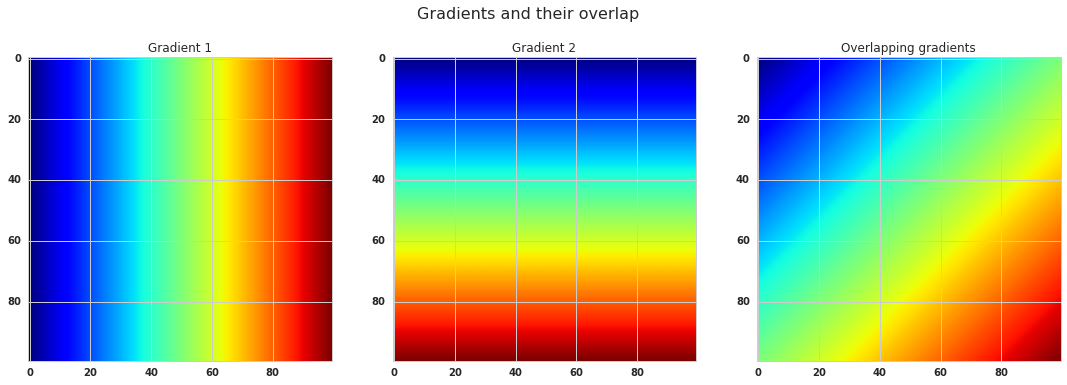

In [114]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
ax1.imshow(gradient1)
ax1.set_title('Gradient 1')
ax2.imshow(gradient2)
ax2.set_title('Gradient 2')
ax3.imshow(gradient1 + gradient2)
ax3.set_title('Overlapping gradients')
fig.suptitle('Gradients and their overlap', fontsize = 16)

#fig = plt.gcf()
fig.set_size_inches(18.5, 6)

## Generation of connectivity matrices
We model this scenario by introducing three 'areas':
1. 2-dimensional, rectangular seed area S, with size Sx x Sy
2. Two 1-dimensional target areas, with sizes T1 and T2

Since the decompositions are performed on connectivity matrices, we have moved straight to creating a connectivity matrix, ommitting the timeseries generation. The function <b>gen_connectivity</b> creates the seed and target regions. The sizes of the regions are specified as parameters. The exact location in the target region is randomized, as well as the standard deviation of connectivity distribution (Gaussian in this case). Randomization of the exact location was introduced to get rid of strong recurring patterns, which were captured by diffusion embedding. Although the presence of additional patterns (aside from two overlapping gradients) has been alleviated with this procedure, it has not been removed completely (see later steps). 

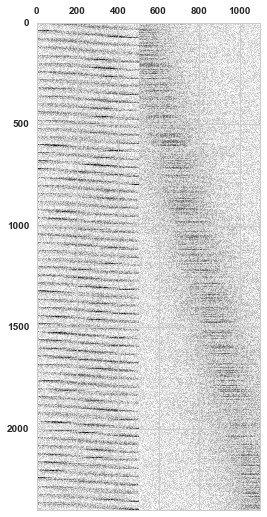

In [77]:
Sx = 40
Sy = 60
T1 = 500
T2 = 600
overlap = 2
snr = 200

C, CN, G = gen_connectivity(Sx, Sy, T1, T2, overlap = overlap, snr = snr, rand_overlap = True, plot = True)

## Embedding of the connectivity matrix
In this step we simply compute the affinity matrix and diffusion embedding with functions available in mapalign. This step has three sub-steps:
1. Generation of affinity matrix based on Euclidean (or Manhattan) distance between points, filtered with a Gaussian kernel with sigma based on the heuristic implemented in mapalign
2. Generation of nearest neighbor graph from the affinity matrix
3. Diffusion embedding

The effects of each step are presented below. The computation of NN graph from affinity matrix is optional and definately augments performance in high noise conditions.

As can be seen below, we manage to accurately recover the two gradients of connectivity, which we have introduced in the data. However, many more structures are captured, which we assume are a by-product of our method of modeling the phenomenon.

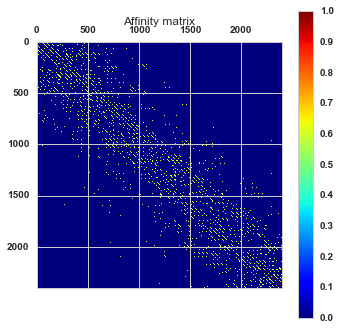

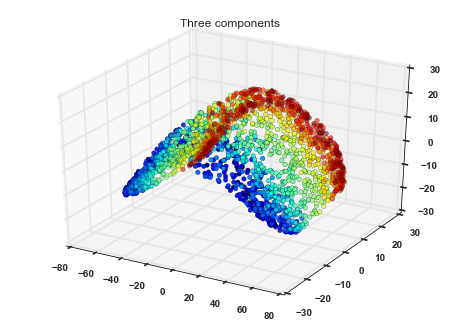

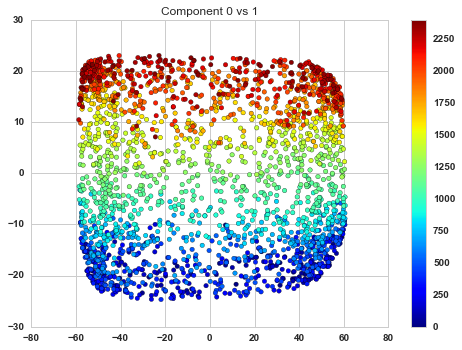

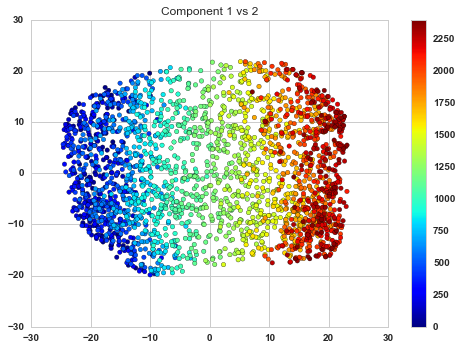

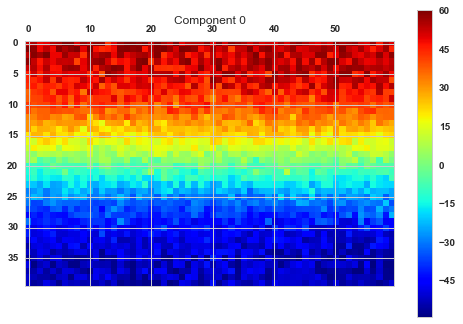

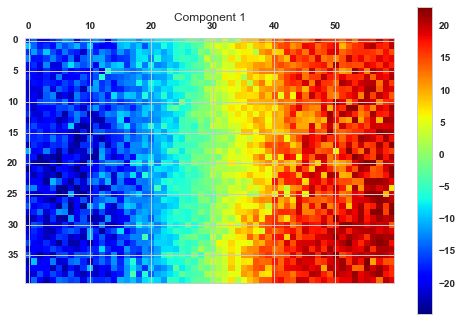

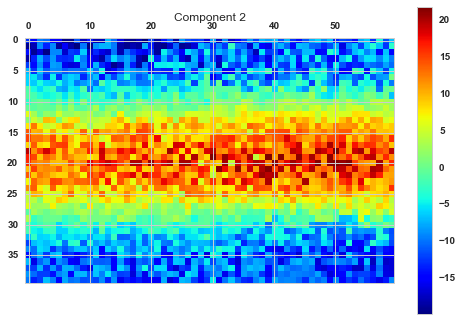

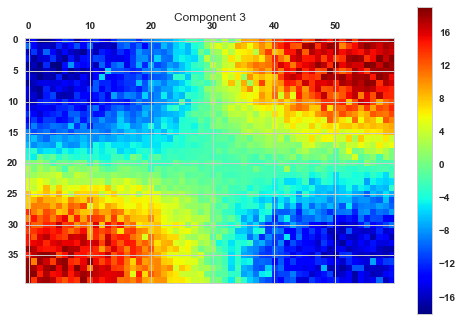

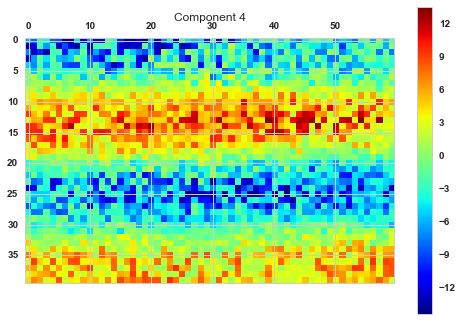

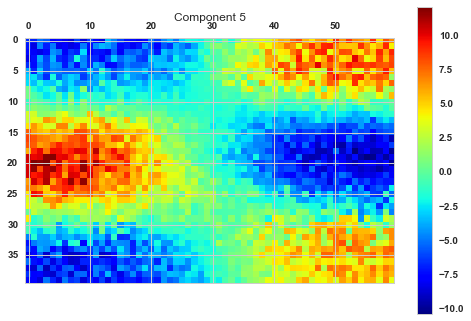

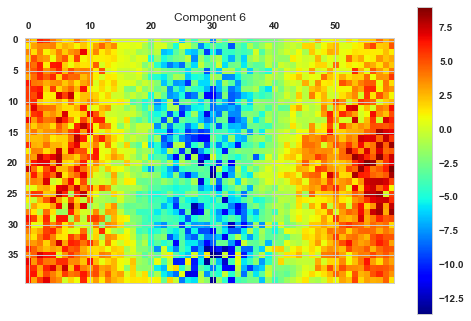

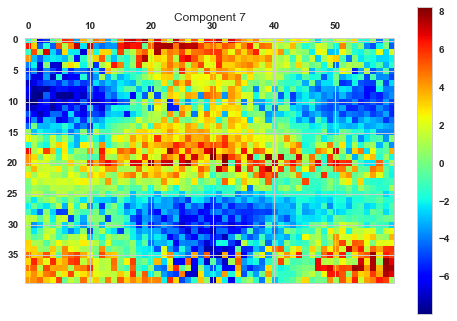

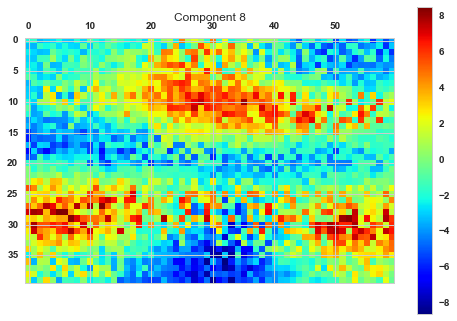

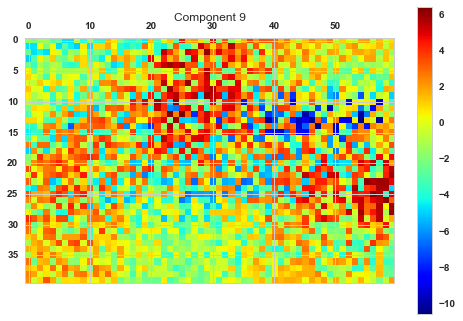

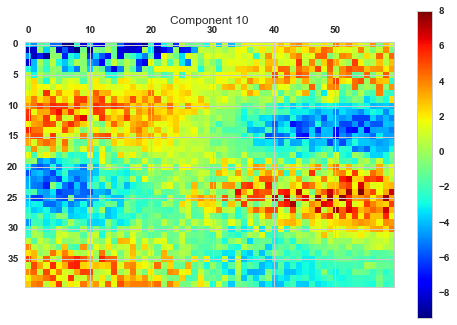

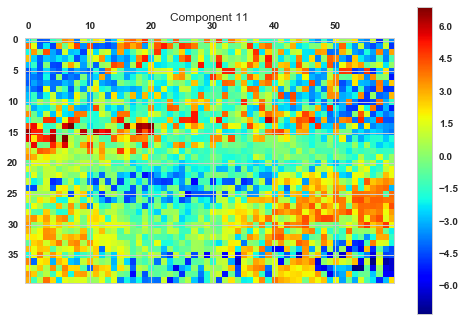

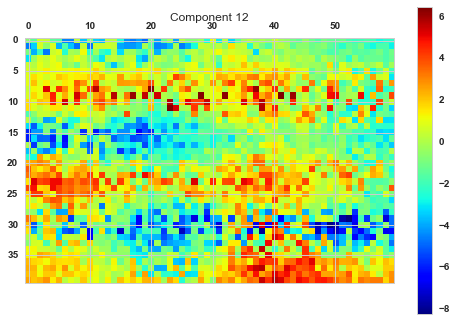

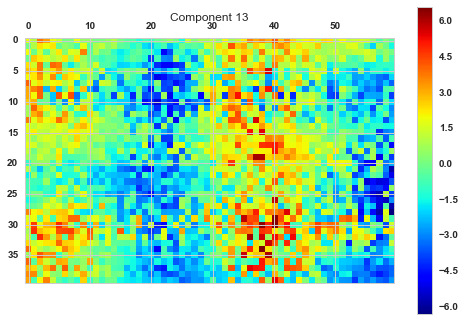

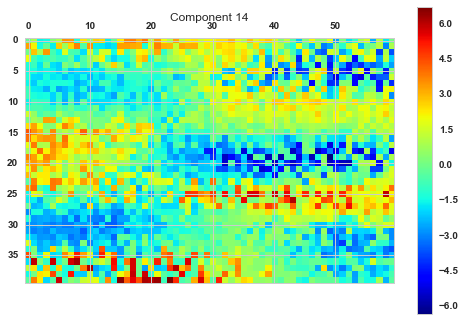

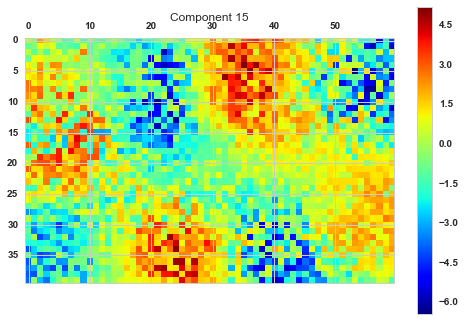

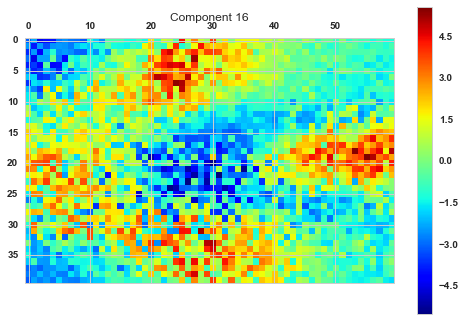

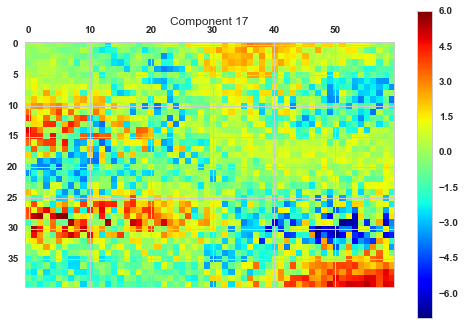

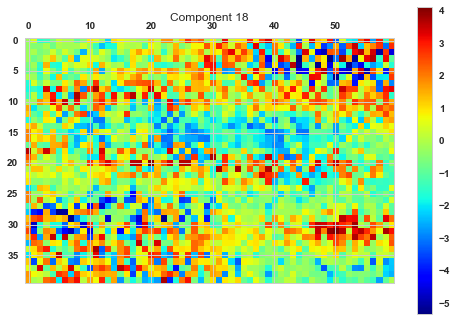

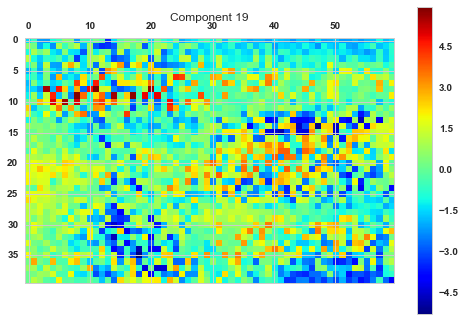

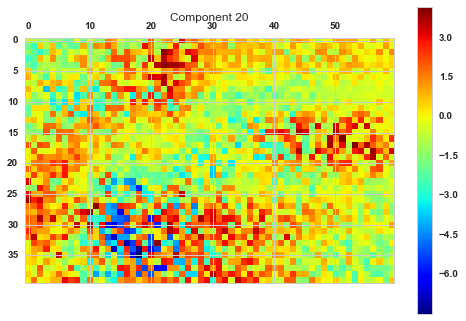

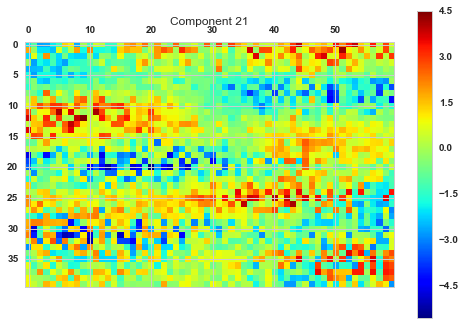

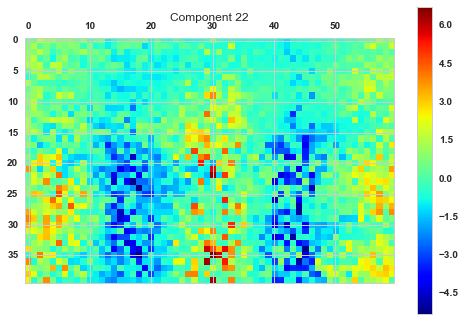

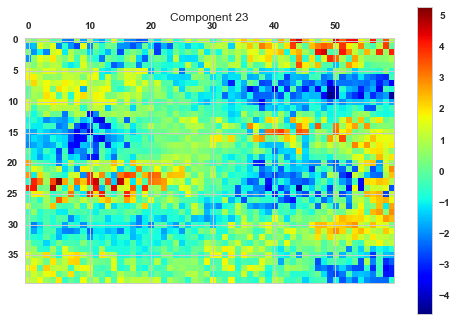

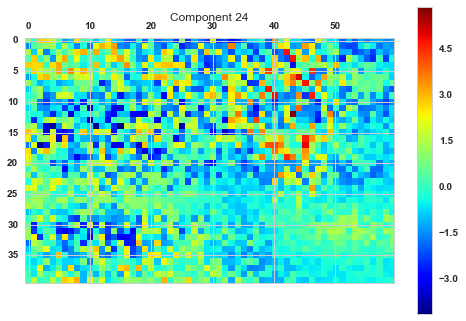

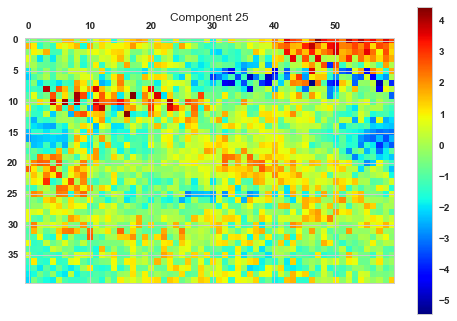

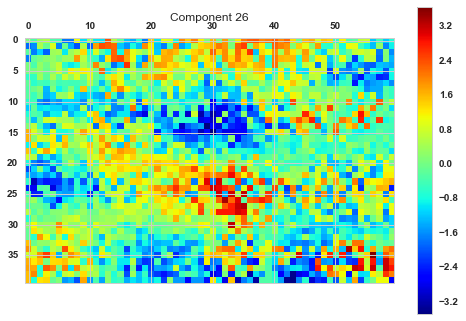

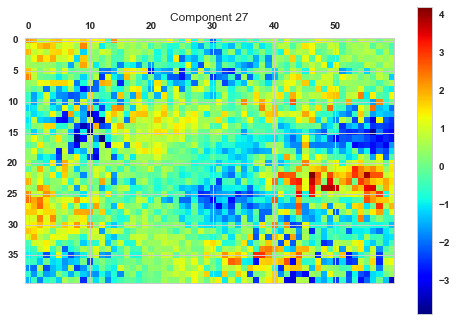

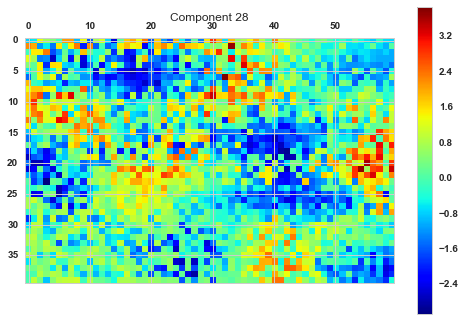

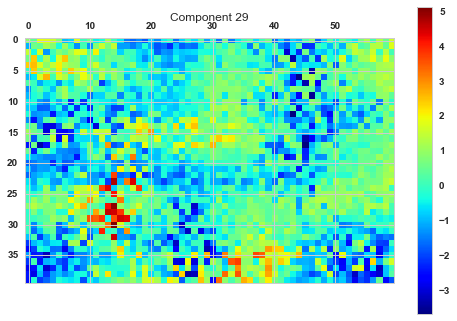

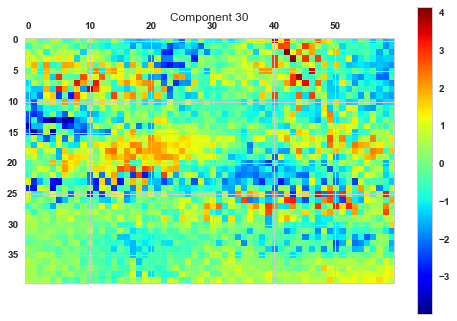

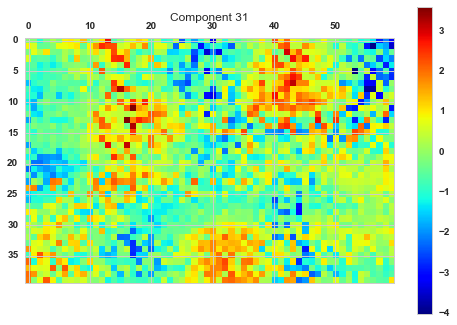

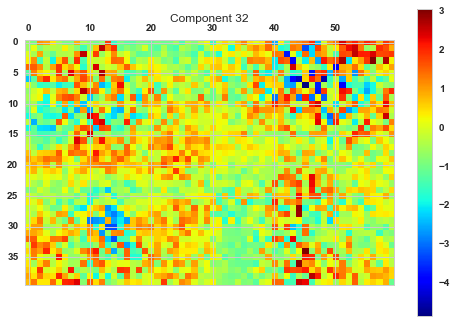

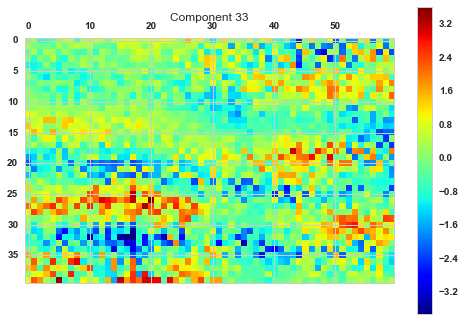

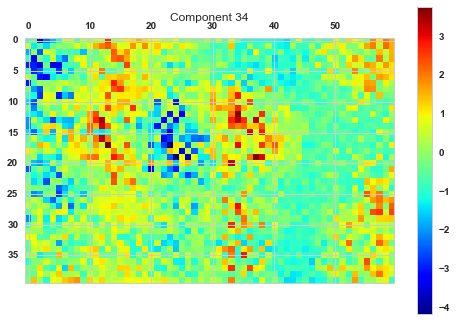

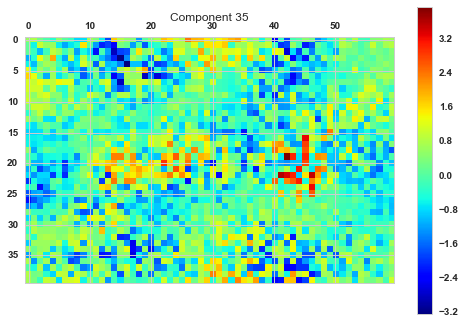

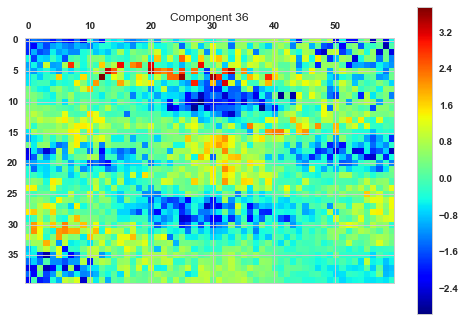

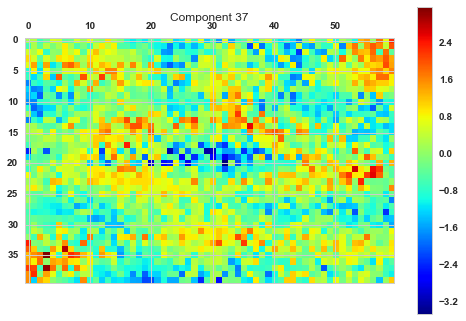

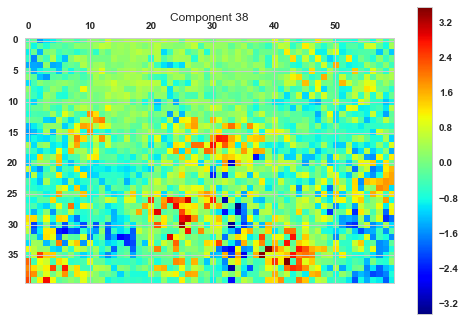

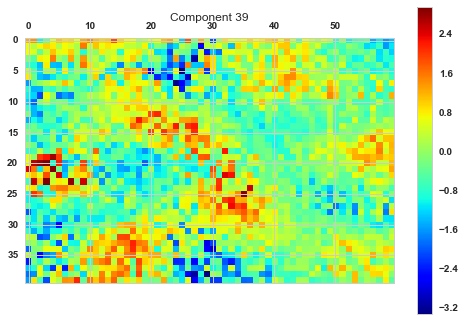

In [79]:
emb, res = gen_gradients(CN,Sx,Sy,metric = 'cityblock', alpha = 0.5, dt = 0, plot = True)

## Realignment

In this step we generate a set of embeddings of connetivity matrices with the same underlying structure, but with different levels of noise and exact distribution of points. We aim to recover the two gradients at the group level. The two methods tested are Generalized Procrustes Analysis (as implemented in mapalign) and STATIS (implemented in pySTATIS package). First we generate the samples and then use both methods to align them together.

Note that Procrustes implementation does not produce the 'template' embedding by default. However, a slight modification of the code allows to return the iteratively generated template.

We generate the data for STATIS and Procrustes in a different way, because STATIS works on normalized left singular vectors (divided by the first component), whereas Procrustes on normalized left singular vectors multiplied by rescaled singular values.

#### Options for the areas

In [86]:
# Options
Sx = 70
Sy = 50
T1 = 1000
T2 = 600
overlap = 2
snr = 200

#### Generate samples

In [87]:
Xs = []
Xp = []

for i in range(30):
    print "Sample %d " % (i+1)
    C, CN, G = gen_connectivity(Sx, Sy, T1, T2, overlap = overlap, snr = snr, rand_overlap = True)
    emb, res = gen_gradients(CN,Sx,Sy,metric = 'cityblock', alpha = 1, dt = 0, plot = False)
    n = res['vectors'][:,0]
    ev = (res['vectors'].T/n).T
    Xs.append(ev[:,1:11])
    Xp.append(emb[:,1:11])

Sample 1 
Sample 2 
Sample 3 
Sample 4 
Sample 5 
Sample 6 
Sample 7 
Sample 8 
Sample 9 
Sample 10 
Sample 11 
Sample 12 
Sample 13 
Sample 14 
Sample 15 
Sample 16 
Sample 17 
Sample 18 
Sample 19 
Sample 20 
Sample 21 
Sample 22 
Sample 23 
Sample 24 
Sample 25 
Sample 26 
Sample 27 
Sample 28 
Sample 29 
Sample 30 


### STATIS

In [88]:
statis_res = pstatis.statis(Xs, '/Users/marcel/projects/tractography_embedding/model1_statis.npy')

Normalizing tables...
Not performing any manipulations on input matrices
Stacking matrices horizontally...
Getting masses for rows and weights for columns...
Computing Z...
Computing C...
Decomposing similarity matrix...
Performing GSVD on the horizontally concatenated matrix...
Calculating contributions of rows, columns and tables...


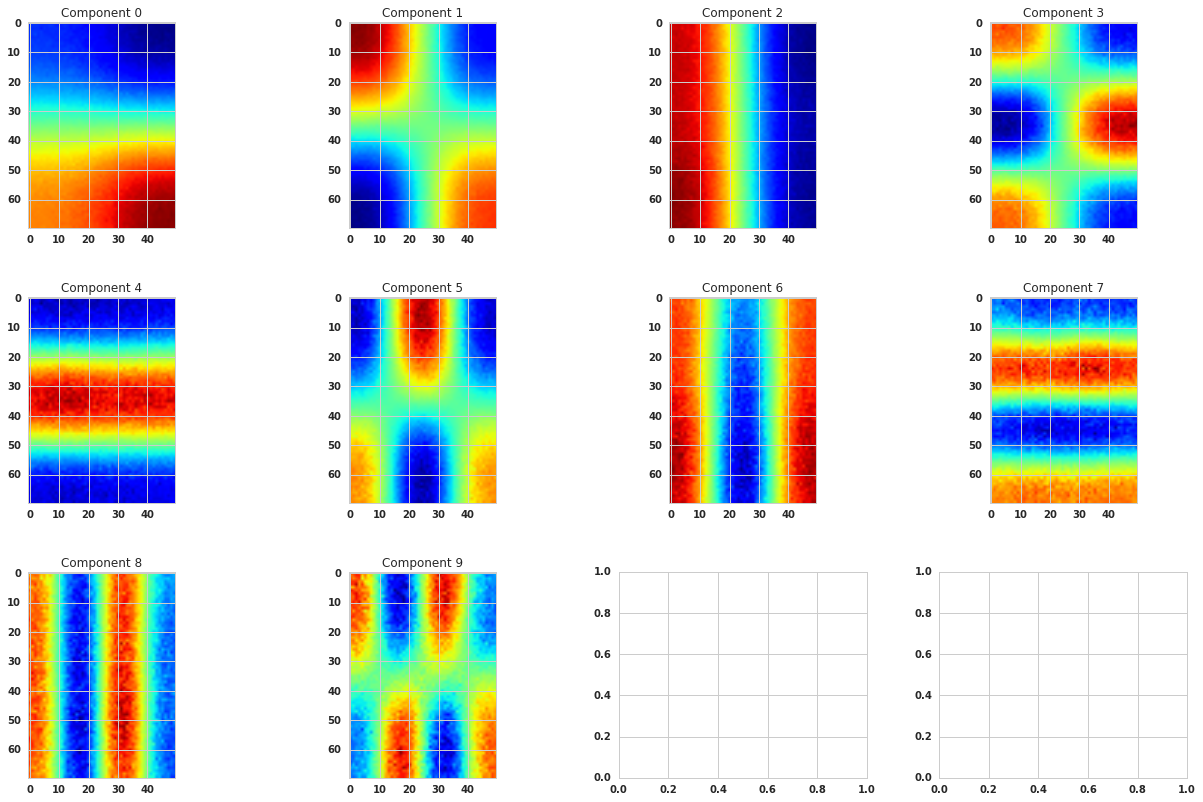

In [157]:
fig, axs = plt.subplots(3, 4)
coords = np.vstack([np.indices((3,4))[0].flatten(),np.indices((3,4))[1].flatten()]).T

for i in range(10):
    R = reconstruct2(statis_res['P'][:,i], Sx, Sy)
    axs[coords[i,0],coords[i,1]].imshow(R)
    axs[coords[i,0],coords[i,1]].set_title('Component %d' % i)

fig.set_size_inches(18, 12)
plt.tight_layout()

STATIS relatively accurately captures the initial gradients (components 0 and 2).

#### Procrustes

In [90]:
procrustes_res, xfms, procrustes_template = align.iterative_alignment(Xp, 50)

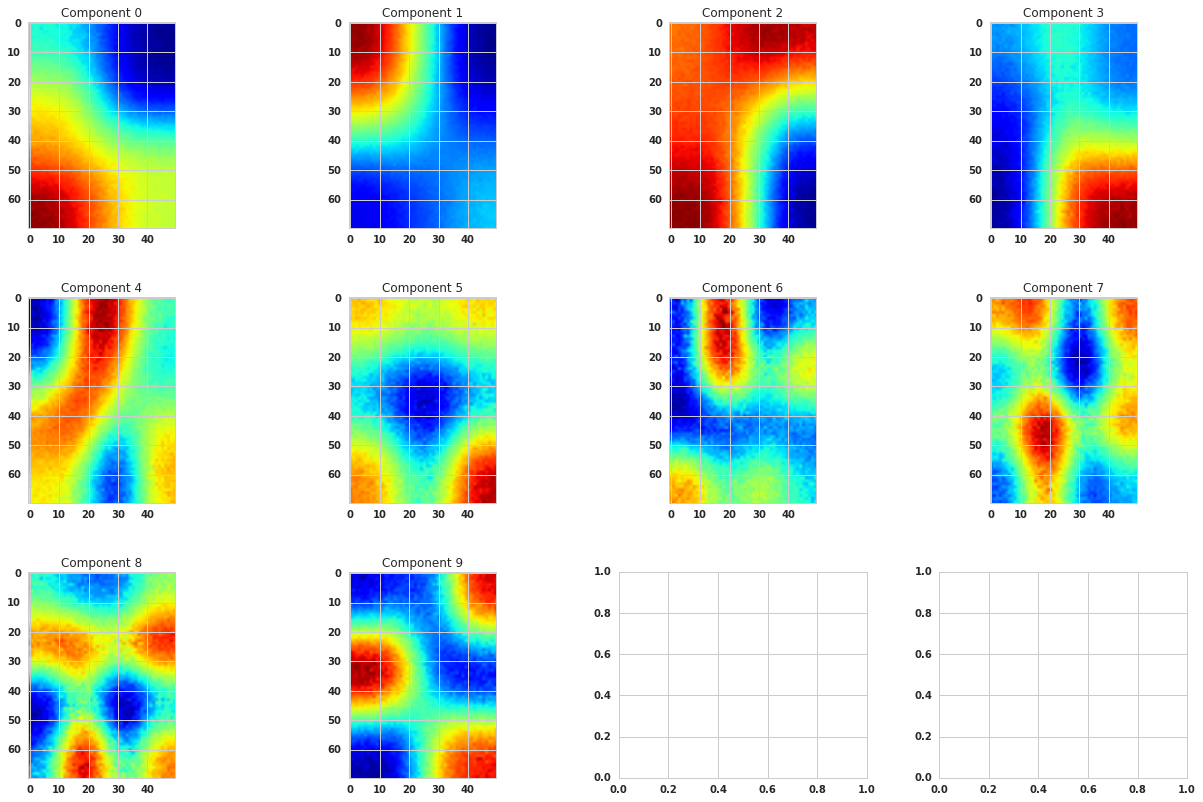

In [156]:
fig, axs = plt.subplots(3, 4)
coords = np.vstack([np.indices((3,4))[0].flatten(),np.indices((3,4))[1].flatten()]).T

for i in range(10):
    R = reconstruct2(procrustes_template[:,i], Sx, Sy)
    axs[coords[i,0],coords[i,1]].imshow(R)
    axs[coords[i,0],coords[i,1]].set_title('Component %d' % i)

fig.set_size_inches(18, 12)
plt.tight_layout()

On the other hand, Procrustes fails completely.